# Figure 4 FG: qPCR data

In [1]:
## Import necessary stuff. 

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Special imports
import utils
import logomaker

%matplotlib inline

In [2]:
# Set figure style
style_file_name = f'fig.style'
s = """
axes.linewidth:     1.0  # width of spines 
font.size:          7.0  # default font size
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0  # fontsize of title
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
axes.labelpad:      1.0     # space between label and axis
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# Load data
qpcr_file_name = '../data/qPCR/smn1_345mutants.xlsx'
val_cols = pd.MultiIndex.from_product([['inclusion', 'exclusion'], range(1,5)],
                                      names=['isoform','techrep'])
df = pd.read_excel(qpcr_file_name, index_col=0, names=val_cols)
df.index = pd.MultiIndex.from_tuples(tuple(df.index.str.split()), 
                                     names=['variant', 'treatment', 'biorep'])
df = df.reset_index()

# Clean up entries
df['variant'] = [val.replace('T','U') 
                      if val!='WT' 
                      else 'WT' for val in df['variant']]
df['treatment'] = df['treatment'].map(
    {'Risd25':'risdiplam',
     'Bran25':'branaplam',
     'DMSO':'DMSO'})
df['biorep'] = [int(val) for val in df['biorep']]

# Melt data
df = df.melt(id_vars=['variant','treatment','biorep'])
df = df.rename(columns={'variable_0':'isoform', 'variable_1':'techrep', 'value':'CT'})

# Compute mean and sem across technical replicates
cols = list(df.columns[:-2])
df = df.groupby(cols)[['CT']].agg(['mean','sem'])
df.columns=['ct_mean','ct_sem']
df.reset_index(inplace=True)

# Compute delta_ct_mean and delta_ct_sem (aggregating across isoforms)
inc_ix = (df['isoform']=='inclusion')
exc_ix = ~inc_ix
index_cols = ['variant','treatment','biorep']
df_inc = df[inc_ix].set_index(index_cols)
df_exc = df[exc_ix].set_index(index_cols)
delta_ct_df = pd.DataFrame(index=df_inc.index)
delta_ct_df['delta_ct_mean'] = df_inc['ct_mean'] - df_exc['ct_mean']
delta_ct_df['delta_ct_sem'] = np.sqrt(df_inc['ct_sem']**2 + df_exc['ct_sem']**2)
delta_ct_df = delta_ct_df.reset_index()
delta_ct_df = delta_ct_df.sort_values(by=index_cols).reset_index(drop=True)
delta_ct_df = delta_ct_df[['variant','biorep','treatment','delta_ct_mean','delta_ct_sem']]
delta_ct_df.head()

,variant,biorep,treatment,delta_ct_mean,delta_ct_sem
0,A3C,1,DMSO,4.668750,0.106343
1,A3C,2,DMSO,4.484512,0.055038
2,A3C,1,branaplam,4.293707,0.088021
3,A3C,2,branaplam,4.305039,0.054425
4,A3C,1,risdiplam,3.199079,0.079573


In [4]:
# Compute dd_ct_mean and dd_ct_sem
def get_dd_ct_df(treatment):
    drug_ix = (delta_ct_df['treatment']==treatment)
    dmso_ix = (delta_ct_df['treatment']=='DMSO')
    index_cols = ['variant','biorep']
    delta_ct_df_drug = delta_ct_df[drug_ix].set_index(index_cols)
    delta_ct_df_dmso = delta_ct_df[dmso_ix].set_index(index_cols)
    dd_ct_df = pd.DataFrame(index=delta_ct_df_drug.index)
    dd_ct_df['dd_ct_mean'] = delta_ct_df_drug['delta_ct_mean'] - delta_ct_df_dmso['delta_ct_mean']
    dd_ct_df['dd_ct_sem'] = np.sqrt(delta_ct_df_drug['delta_ct_sem']**2 + delta_ct_df_dmso['delta_ct_sem']**2)
    dd_ct_df = dd_ct_df.reset_index()
    dd_ct_df = dd_ct_df.sort_values(by=['variant','biorep']).reset_index(drop=True)
    return dd_ct_df

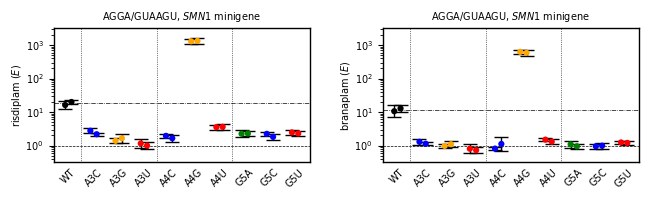

In [5]:
def plot_qPCR(ax, treatment):

    char_to_color_dict = {'G': [1, 0.65, 0],
                          'U': [1, 0, 0],
                          'C': [0, 0, 1],
                          'A': [0, 0.5, 0]}

    # Get dataframe
    dd_ct_df = get_dd_ct_df(treatment=treatment)
    
    # Order the variants so WT comes first
    dd_ct_df['is_not_wt'] = ~dd_ct_df['variant'].str.match('WT')
    dd_ct_df = dd_ct_df.sort_values(by=['is_not_wt','variant','biorep'])
    dd_ct_df.drop(columns='is_not_wt', inplace=True)   
    dd_ct_df.reset_index(drop=True, inplace=True)
    
    x=dd_ct_df.index.values
    x = x - .5*(x%2-.5) # add stagger
    log2_z=-dd_ct_df['dd_ct_mean']
    log2_dz=dd_ct_df['dd_ct_sem']
    z = 2**log2_z
    z_lo = 2**(log2_z-1.96*log2_dz)
    z_hi = 2**(log2_z+1.96*log2_dz)
    zerr = [z-z_lo, z_hi-z]
    
    colors = [char_to_color_dict.get(var[-1], 'k') for var in dd_ct_df['variant']]
    ax.scatter(x, z, color=colors, alpha=1, s=20, linewidth=0)
    ax.errorbar(x=x, y=z, yerr=zerr, color='k', linewidth=0, elinewidth=1, capsize=5, zorder=-100)
            
    # Plot horizontal line for mean ddCT of WT
    y_wt = z[:2].mean()
    ax.axhline(y_wt, color='k', linewidth=.5, linestyle='-.', zorder=-100)
    ax.axhline(1, color='k', linewidth=.5, linestyle='--', zorder=-100)

    for x_vert in [1.5, 7.5, 13.5]:
        ax.axvline(x_vert, color='k', linestyle=':', linewidth=.5)
    
    kwargs = dict(yscale='log',
                  ylabel=fr'{treatment} ($E$)',
                  #title=fr'$\bf{{AG}}$GA/GUAAGU',
                  title=fr'AGGA/GUAAGU, $SMN1$ minigene',
                  xticks=np.arange(10)*2+.5,
                  xticklabels = dd_ct_df['variant'][::2],
                  yticks=[10**0, 10**1, 10**2, 10**3],
                  ylim=[10**-0.5, 10**3.5])
    ax.tick_params(axis='x', rotation=45)

    ax.set(**kwargs)
    ax.tick_params('x', length=0)

fig, axs = plt.subplots(1,2,figsize=[6.5,2])
plot_qPCR(axs[0], treatment='risdiplam')
plot_qPCR(axs[1], treatment='branaplam')

fig.tight_layout(w_pad=3)
file_name = f'fig4FG.pdf'
fig.savefig(file_name)